In [1]:
import pandas as pd
import os
import pathlib
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.ticker

import flight_path

# BARREL 3G and 3F Ephemeris and Fast Spectra
The goal is to explore the trajectory of the two balloons to determine how close they were during campaign 3 and look at how similar the fast spectra is between the two payloads

In [2]:
top_dir = '/home/mike/research/barrel/data/campaign_3'
match_name = 'bar_*_l2_ephm_*.cdf'
flight_dates = ['20150825', '20150826'] # Flight days to plot
save_ephem = True
save_fs = True

ephem_paths = sorted(pathlib.Path(top_dir).rglob(match_name), 
                key=lambda i: i.name.split('_')[4])
for path in ephem_paths:
    print(path.name)

bar_3A_l2_ephm_20150810_v05.cdf
bar_3B_l2_ephm_20150813_v05.cdf
bar_3C_l2_ephm_20150817_v05.cdf
bar_3C_l2_ephm_20150818_v05.cdf
bar_3D_l2_ephm_20150819_v05.cdf
bar_3E_l2_ephm_20150821_v05.cdf
bar_3E_l2_ephm_20150822_v05.cdf
bar_3G_l2_ephm_20150825_v05.cdf
bar_3F_l2_ephm_20150825_v05.cdf
bar_3G_l2_ephm_20150826_v05.cdf
bar_3F_l2_ephm_20150826_v05.cdf


In [3]:
# Make a dictionary of dictionaries. The parent level dictionary
# has the dates and the child dictionary has the payloads that 
# flew on those days.
ephem_dict = {date:{} for date in flight_dates}

# Sort through the found files.
for path in ephem_paths:
    flight_date = path.name.split('_')[4]
    payload = path.name.split('_')[1]

    if flight_date in flight_dates:
        # Load the ephemeris data into ephem dictionary with date keys.
        # For each key date, save the dataframe into a payload dictionary.
        ephem_dict[flight_date][payload] = flight_path.load_barrel_ephem(str(path))

merged_ephem = {}

for date in ephem_dict:
    merged_ephem[date] = flight_path.merge_ballon_positions(ephem_dict[date])

merged_ephem = flight_path.merge_ballon_time(merged_ephem)

merged_ephem['dist_km'] = flight_path.haversine(merged_ephem[['3G_GPS_Lat', '3G_GPS_Lon', '3G_GPS_Alt']], 
                                               merged_ephem[['3F_GPS_Lat', '3F_GPS_Lon', '3F_GPS_Alt']])
if save_ephem:
    merged_ephem.to_csv('BARREL_merged_ephemeris.csv')

In [4]:
merged_ephem.head()

,3G_GPS_Alt,3G_GPS_Lat,3G_GPS_Lon,3G_L_Kp2,3G_L_Kp6,3G_MLT_Kp2_T89c,3G_MLT_Kp6_T89c,3F_GPS_Alt,3F_GPS_Lat,3F_GPS_Lon,3F_L_Kp2,3F_L_Kp6,3F_MLT_Kp2_T89c,3F_MLT_Kp6_T89c,dist_km
2015-08-25 09:15:43.167032,5.004198,67.905930,21.175816,5.73,6.47,11.99,11.99,36.344952,68.063385,21.156187,5.82,6.61,12.00,12.00,17.527351
2015-08-25 09:15:47.166536,5.022342,67.905922,21.176367,5.73,6.47,11.99,11.99,36.344921,68.063522,21.155985,5.82,6.61,12.00,12.00,17.544945
2015-08-25 09:15:51.166039,5.040431,67.905907,21.176918,5.73,6.47,12.00,12.00,36.344833,68.063660,21.155781,5.82,6.61,12.00,12.00,17.563442
2015-08-25 09:15:55.165543,5.058591,67.905876,21.177479,5.73,6.47,12.00,12.00,36.344677,68.063797,21.155573,5.82,6.61,12.01,12.01,17.583717
2015-08-25 09:15:59.165046,5.076752,67.905846,21.178053,5.73,6.47,12.00,12.00,36.344482,68.063942,21.155365,5.82,6.61,12.01,12.01,17.604925


### Downsample to 100 points

In [5]:
n_plot = 100
merged_ephem_downsampled = merged_ephem.iloc[::merged_ephem.shape[0]//n_plot]

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


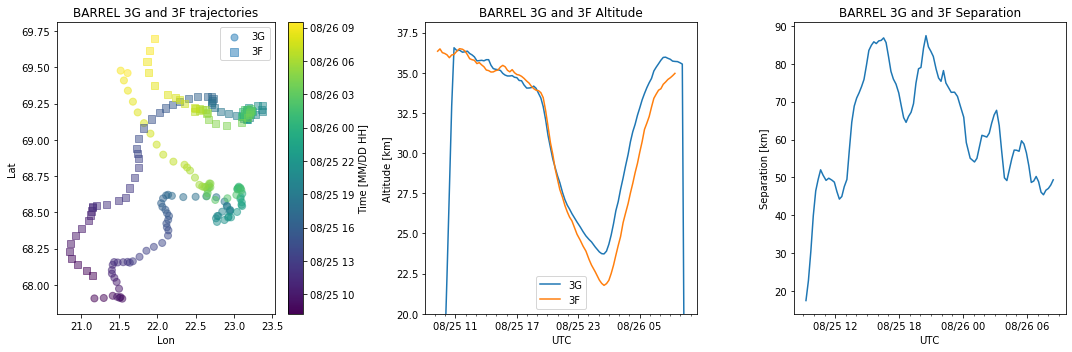

In [6]:
sm = plt.cm.ScalarMappable(cmap='viridis', 
                           norm=plt.Normalize(vmin=merged_ephem.index.min().value,
                                              vmax=merged_ephem.index.max().value))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sc = ax[0].scatter(merged_ephem_downsampled['3G_GPS_Lon'], merged_ephem_downsampled['3G_GPS_Lat'], 
                    c=merged_ephem_downsampled.index, marker='o', s=50, alpha=0.5, label='3G')
ax[0].scatter(merged_ephem_downsampled['3F_GPS_Lon'], merged_ephem_downsampled['3F_GPS_Lat'], 
                    c=merged_ephem_downsampled.index, marker='s', s=50, alpha=0.5, label='3F')
cbar = plt.colorbar(sm, ax=ax[0], label='Time [MM/DD HH]')
# Change the numeric ticks into ones that match the x-axis
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%m/%d %H'))

ax[1].plot(merged_ephem_downsampled.index, merged_ephem_downsampled['3G_GPS_Alt'], label='3G')
ax[1].plot(merged_ephem_downsampled.index, merged_ephem_downsampled['3F_GPS_Alt'], label='3F')
             
ax[2].plot(merged_ephem_downsampled.index, merged_ephem_downsampled['dist_km'])

ax[0].set(title=f'BARREL 3G and 3F trajectories', 
          xlabel='Lon', ylabel='Lat')
ax[1].set(title=F'BARREL 3G and 3F Altitude', ylabel='Altitude [km]',
          xlabel=f'UTC', ylim=(20, None))
ax[2].set(title=F'BARREL 3G and 3F Separation', ylabel='Separation [km]',
          xlabel=f'UTC')

# Format ax[1] and ax[2] x axis
time_fmt = matplotlib.dates.DateFormatter('%m/%d %H')
for a in ax[1:]:
    a.xaxis.set_major_formatter(time_fmt)
    a.xaxis.set_major_formatter(time_fmt)
    a.xaxis.set_minor_locator(matplotlib.dates.HourLocator(interval=1))
    a.xaxis.set_major_locator(matplotlib.dates.HourLocator(interval=6))

ax[0].legend()
ax[1].legend()

plt.tight_layout()
#plt.savefig('20150825_BARREL_3G_3F_trajectories.pdf')

# Now load the Fast Spectra from 25 and 26 August 2015.

In [7]:
fs_match_name = 'bar_*_l2_fspc_*.cdf'
flight_dates = ['20150825', '20150826'] # Flight days to plot

fs_paths = sorted(pathlib.Path(top_dir).rglob(fs_match_name), 
                key=lambda i: i.name.split('_')[4])
for fs in fs_paths:
    print(fs.name)

bar_3A_l2_fspc_20150810_v05.cdf
bar_3B_l2_fspc_20150813_v05.cdf
bar_3C_l2_fspc_20150817_v05.cdf
bar_3C_l2_fspc_20150818_v05.cdf
bar_3D_l2_fspc_20150819_v05.cdf
bar_3E_l2_fspc_20150821_v05.cdf
bar_3E_l2_fspc_20150822_v05.cdf
bar_3G_l2_fspc_20150825_v05.cdf
bar_3F_l2_fspc_20150825_v05.cdf
bar_3G_l2_fspc_20150826_v05.cdf
bar_3F_l2_fspc_20150826_v05.cdf


In [8]:
# Make a dictionary of dictionaries. The parent level dictionary
# has the dates and the child dictionary has the payloads that 
# flew on those days.
fs_dict = {date:{} for date in flight_dates}

# Sort through the found files.
for path in fs_paths:
    flight_date = path.name.split('_')[4]
    payload = path.name.split('_')[1]

    if flight_date in flight_dates:
        # Load the ephemeris data into ephem dictionary with date keys.
        # For each key date, save the dataframe into a payload dictionary.
        fs_dict[flight_date][payload] = flight_path.load_barrel_spectra(str(path))

merged_fs = {}

for date in fs_dict:
    merged_fs[date] = flight_path.merge_ballon_positions(fs_dict[date])

merged_fs = flight_path.merge_ballon_time(merged_fs)

if save_fs:
    merged_fs.to_csv('BARREL_merged_fast_spectra.csv')

### Filter by time and plot

In [9]:
filtered_fs = merged_fs['20150825T09:00:00':'20150826T9:00:00']

if filtered_fs.shape[0] > 100_000:
    # Downsample to make plotting faster
    filtered_fs = filtered_fs.loc[::filtered_fs.shape[0]//100_000]

/home/mike/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


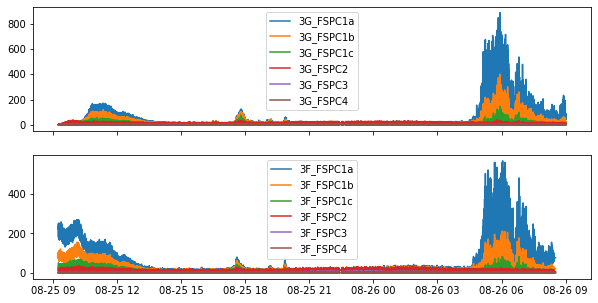

In [10]:
fig, bx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

for column in filtered_fs.columns:
    if '3G' in column: 
        plt_num=0
    else:
        plt_num=1
    bx[plt_num].plot(filtered_fs.index, filtered_fs[column], label=column)

bx[0].legend()
bx[1].legend();
#plt.savefig('20150825_BARREL_3G_3F_fast_spectra.pdf')

# Make Summary plots

In [11]:
xlabel_variables = ['3G_L_Kp2', '3G_MLT_Kp2', '3G_GPS_Alt', '3F_GPS_Alt']
i = 0
label_values = lambda i: str(list(merged_ephem.loc[merged_ephem.index[i], xlabel_variables].values.flatten())).replace(', ', '\n')
label_values(i)

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


'[5.73\nnan\n5.004198\n36.34495]'

In [12]:
merged_ephem['20150826T04:00:00':'20150826T09:00:00']

,3G_GPS_Alt,3G_GPS_Lat,3G_GPS_Lon,3G_L_Kp2,3G_L_Kp6,3G_MLT_Kp2_T89c,3G_MLT_Kp6_T89c,3F_GPS_Alt,3F_GPS_Lat,3F_GPS_Lon,3F_L_Kp2,3F_L_Kp6,3F_MLT_Kp2_T89c,3F_MLT_Kp6_T89c,dist_km
2015-08-26 04:00:02.664383,30.291063,68.674103,22.656425,6.46,9.67,6.97,6.97,27.196463,69.100998,22.836424,6.72,10.31,7.01,7.01,48.012867
2015-08-26 04:00:06.663876,30.297192,68.674225,22.656719,6.46,9.67,6.97,6.97,27.199051,69.101013,22.835770,6.72,10.31,7.01,7.01,47.995430
2015-08-26 04:00:10.663369,30.303089,68.674355,22.657017,6.46,9.67,6.97,6.97,27.201666,69.101028,22.835112,6.72,10.30,7.01,7.01,47.977139
2015-08-26 04:00:14.662862,30.308855,68.674461,22.657316,6.46,9.67,6.98,6.98,27.204491,69.101044,22.834455,6.72,10.30,7.01,7.01,47.961399
2015-08-26 04:00:18.662355,30.314636,68.674576,22.657623,6.46,9.67,6.98,6.98,27.207577,69.101067,22.833801,6.72,10.30,7.01,7.01,47.945641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-26 08:59:44.378769,35.632488,69.423279,21.551397,6.48,7.53,11.86,11.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-26 08:59:48.378266,35.633144,69.423584,21.551153,6.48,7.53,11.86,11.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-26 08:59:52.377763,35.633846,69.423882,21.550909,6.48,7.53,11.87,11.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-26 08:59:56.377260,35.634590,69.424187,21.550667,6.48,7.53,11.87,11.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
xlabel_variables = ['3G_L_Kp2', '3G_MLT_Kp2_T89c', '3G_GPS_Alt', '3F_GPS_Alt', 'dist_km']

xlabel_func = lambda i: (str(merged_ephem.index[i].date()) + '\n' + 
                        str(merged_ephem.index[i].strftime("%H:%M:%S")) + '\n' +
                        str(list(merged_ephem.loc[merged_ephem.index[i], xlabel_variables].round(1).values.flatten()
                            )).replace(', ', '\n').replace('[', '').replace(']', '')
                        )

def format_fn(tick_val, tick_pos):
    """
    The tick magic happens here. pyplot gives it a tick time, and this function 
    returns the closest label to that time. Read docs for FuncFormatter().
    """
    numeric_time = matplotlib.dates.date2num(merged_ephem.index)
    idx = np.argmin(np.abs(numeric_time-tick_val))
    return xlabel_func(idx)

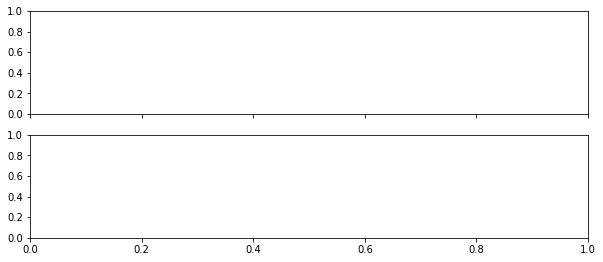

In [14]:
time_freq = '5min'
times = pd.date_range('20150826T04:30:00', '20150826T08:25:00', freq=time_freq)

fig, cx = plt.subplots(2, 1, sharex=True, figsize=(10, 5), sharey=True)

for start_time, end_time in zip(times[:-1], times[1:]):
    filtered_fs = merged_fs[start_time:end_time]

    if filtered_fs.shape[0] > 100_000:
        # Downsample to make plotting faster
        filtered_fs = filtered_fs.loc[::filtered_fs.shape[0]//100_000]

    for column in filtered_fs.columns:
        if '3G' in column: 
            plt_num=0
        else:
            plt_num=1
        cx[plt_num].plot(filtered_fs.index, filtered_fs[column], label=column)

    for c in cx:
        c.legend(loc=1, bbox_to_anchor=(1.1, 1.05))
        c.xaxis.set_minor_locator(matplotlib.dates.SecondLocator(bysecond=[30]))
        c.grid(which='both', linestyle='--')

    cx[-1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_fn))
    cx[-1].set_xlabel("date\ntime\n"+'\n'.join(xlabel_variables))
    cx[-1].xaxis.set_label_coords(-0.07,-0.06)
    plt.subplots_adjust(bottom=0.25)

    save_name = (f'{datetime.strftime(start_time, "%Y%m%d_%H%M")}_'
                f'{datetime.strftime(end_time, "%H%M")}_BARREL_'
                '3G_3F_fast_spectra.png')
    plt.savefig(os.path.join('plots', time_freq, save_name), dpi=200)
    cx[0].clear()
    cx[1].clear()